In [2]:
sys.path.insert(1, '/Users/lucahartman/Documents/EPFL/MA1/project/ecal_reco/tracking/')
sys.path.insert(1, '/Users/lucahartman/Documents/EPFL/MA1/project/ecal_reco/utils/')
from data_loading import *
from hit import Hit
from track3D import Track3D
from track import Track
import pandas as pd
import uproot
#import uproot3
import numpy as np
# import track_time_calibration as ttc
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import sys
from tqdm import tqdm
import scienceplots
plt.style.use(['science', 'grid', 'ieee'])
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Computer Modern Roman",
    'text.latex.preamble': [r'\usepackage{amsmath} \usepackage{amssymb} \usepackage{siunitx}'],
    'figure.dpi': 140,
    'font.size': 14,
    'axes.grid': True
})


In [3]:
# later, one can use concatenation of data_0001.root - data_0008.root files as well. One is enough for testing
file_path = '/Users/lucahartman/Documents/EPFL/MA1/project/ecal_reco/geant4/data_decay6.root'

# branch_list = ['E', 'Edep', 'pdg', 'EcalEdep',
#                'layerID', 'barID', 'Nhits', 'tx', 'ty', 'x0', 'y0', 'n_sec',
#                'ProcessID', 'x_decay', 'y_decay', 'z_decay', 'size_XY', 'size_Z']
# with uproot.open(file_path) as tree:
#         hits_dict = tree['events'].arrays(branch_list, library="np")
# df_hits = pd.DataFrame.from_dict(hits_dict)

branch_list_detector = ['E', 'pdg', 'EcalEdep', 'layerID', 'barID', 'Nhits', 'Edep_e', 'Edep_mu']
branch_list_run = ['E', 'Edep', 'tx', 'ty', 'x0', 'y0', 'n_sec', 'ProcessID', 'x_decay', 'y_decay', 'z_decay', 'size_XY', 'size_Z']
branch_list_electrons = ['E', 'Vertex_E', 'muID']
with uproot.open(file_path) as tree:
        detector_dict = tree['detector'].arrays(branch_list_detector, library="np")
        run_dict = tree['run'].arrays(branch_list_run, library="np")
        electrons_dict = tree['electrons'].arrays(branch_list_electrons, library="np")

df_detector = pd.DataFrame.from_dict(detector_dict)
df_run = pd.DataFrame.from_dict(run_dict)
df_electrons = pd.DataFrame.from_dict(electrons_dict)
df = pd.concat([df_run, df_detector, df_electrons], axis=1)

In [4]:
def theoretical_spectrum(E, A):
    # source https://iopscience.iop.org/article/10.1088/0370-1328/84/2/306
    x = E/52.82
    rho = 0.661
    if E <= 52.82:
        return A * 4*x**2*(3*(1-x) + 2 * rho * (4*x/3 + 1))
    else:
        return 0

In [5]:
electron_energy = []
for index, row in tqdm(df_electrons.iterrows(), total = df_electrons.shape[0]):
    electron_energy.extend(row['E'])
electron_energy = np.array(electron_energy)

100%|██████████| 100000/100000 [00:01<00:00, 51718.94it/s]


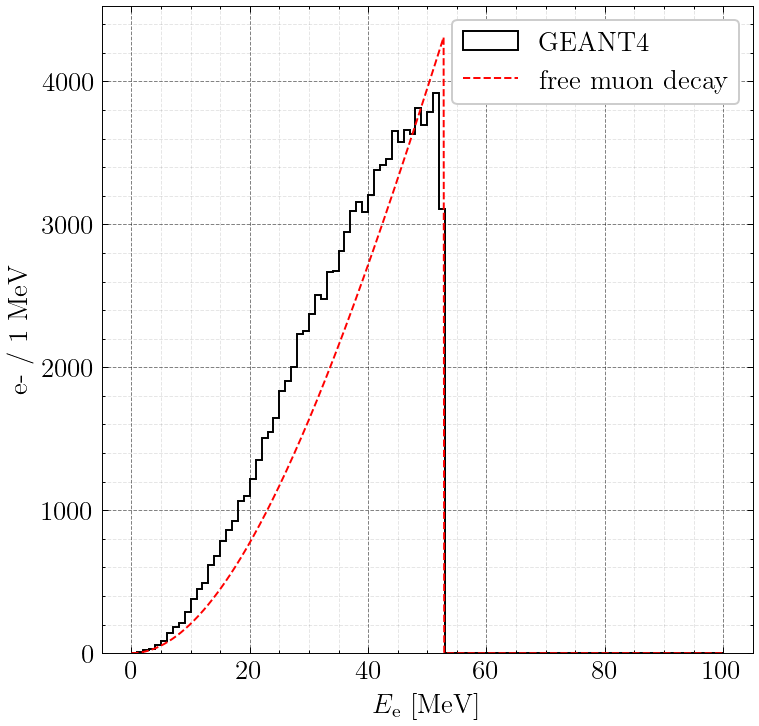

In [27]:
plt.figure(figsize=(6,6))
plt.hist(electron_energy, bins = 100, range = [0, 100], histtype='step', label = 'GEANT4')
Es = np.linspace(0, 100, 1000)
plt.plot(Es, [theoretical_spectrum(E, 350) for E in Es], label = 'free muon decay')
plt.xlabel(r'$E_\mathrm{e}$ [MeV]')
plt.ylabel(r'e- / $1$ MeV')
plt.grid(which = 'major', alpha = 0.5)
plt.grid(which = 'minor', alpha = 0.1)
plt.legend()
plt.savefig('../../../figs/electron_spectrum.pdf')


In [31]:
edep = []
all_edep = []
layer = 5
bar = 12
for index, row in tqdm(df.iterrows(), total = df.shape[0]):
   edep.extend([row['Edep_e'][i] for i in range(len(row['Edep_e'])) if row['layerID'][i] == layer and row['barID'][i] == bar and row['Edep_e'][i] > 0])
   all_edep.extend([row['Edep_e'][i] for i in range(len(row['Edep_e'])) if row['Edep_e'][i] > 0])


100%|██████████| 100000/100000 [07:40<00:00, 216.93it/s]


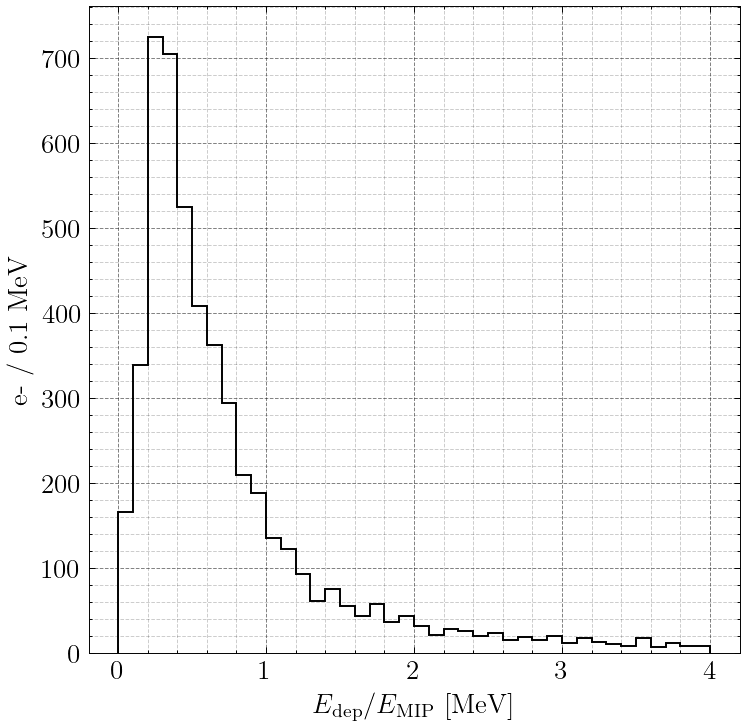

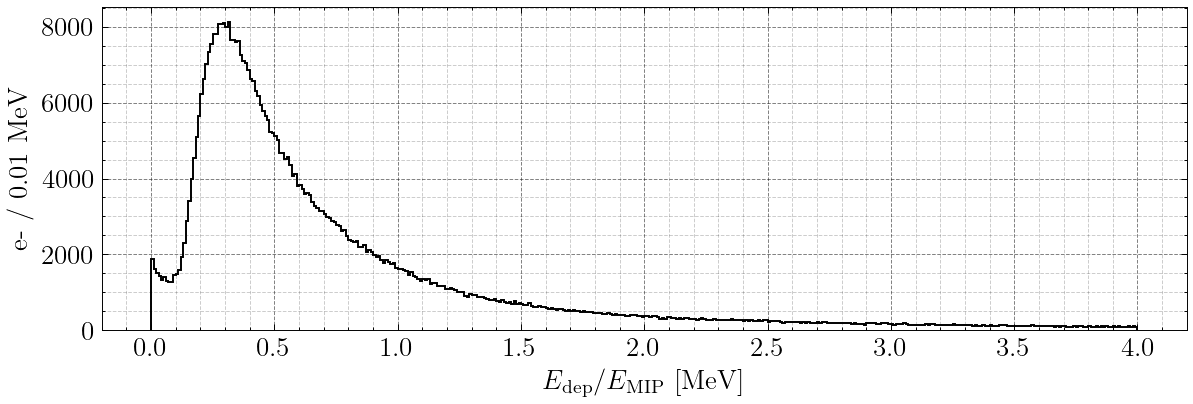

In [33]:

plt.figure(figsize=(6,6))
plt.hist(np.array(edep)/0.914, bins = 40, range = [0, 4], histtype='step')
plt.xlabel(r'$E_\mathrm{dep}/E_\mathrm{MIP}$ [MeV]')
plt.ylabel(r'e- / $0.1$ MeV')
plt.grid(which='major', alpha=0.5)
plt.grid(which='minor', alpha=0.2)
plt.savefig('../../../figs/electron_spectrum_per_cell.pdf')

plt.figure(figsize=(10, 3))
plt.hist(np.array(all_edep)/0.914, bins = 400, range = [0, 4], histtype='step')
plt.xlabel(r'$E_\mathrm{dep}/E_\mathrm{MIP}$ [MeV]')
plt.ylabel(r'e- / $0.01$ MeV')
plt.grid(which='major', alpha=0.5)
plt.grid(which='minor', alpha=0.2)
plt.savefig('../../../figs/electron_spectrum_all_cells.pdf')
